In [1]:
from numpy import *
from matplotlib.pyplot import *
import scipy

from optics_design_workbench import jupyter_utils

[freecad.optics_design_workbench] python package path /usr/lib/python3.11/site-packages exists on filesystem but not in sys.path, appending to sys.path...
[freecad.optics_design_workbench] python package path /usr/lib/python3.12/site-packages exists on filesystem but not in sys.path, appending to sys.path...
[Optics Design 16:19:58.883304] failed to detect Qt version, used module "PySide6"


# Open FreeCAD Gui if desired

In [21]:
# prefer using this cell to open the FreeCAD Gui. This call is blocking
# until FreeCAD is closed again, which helps to avoid editing a FCStd 
# file from jupyter and the FreeCAD Gui in parallel.

jupyter_utils.openFreecadGui()

[Optics Design 16:30:42.361543] FreeCAD finished (exit code -15)


KeyboardInterrupt: 

# Run simulations for various lens radii

In [2]:
simulationMode = 'true'
#simulationMode = 'fans'

In [4]:
# prepare arrays/lists for parameters/results
radii = linspace(36, 58, 20)
results = []

# open FCStd Document as a context manager. The context manager makes sure
# the file is closed again with certainty. Keep in mind that if the file is
# open in another FreeCAD GUI, saving from the Gui will overwrite the file
# and may leads to inconsistent file versions being seen by different 
# worker processes.
with jupyter_utils.FreecadDocument() as f:

  # setup progress tracking
  jupyter_utils.setupProgressTracker(totalSimulations=len(radii))

  # try different radii
  for rad in radii:

    # update radius and placement of both spheres that form the lens
    f.Sphere001.Radius = rad
    f.Sphere001.Placement.Base = [0, 0, -rad/1.2]
    f.Sphere.Radius = rad
    f.Sphere.Placement.Base = [0, 0, rad/1.2]

    # run a simulation
    results.append( f.runSimulation(simulationMode) )


simulations done 20/20
simulations ended after 1m 58s


In [5]:
# show list of the first ten results
results[:10]

[<RawFolder simulation-run-000143/ UID=f29fb33c-8d25-4e92-a769-05a5744074b4>,
 <RawFolder simulation-run-000144/ UID=29327c8b-8087-4ee4-9bc5-fe992eef7764>,
 <RawFolder simulation-run-000145/ UID=1b020f65-a285-46e0-a2f1-21ae9eb27086>,
 <RawFolder simulation-run-000146/ UID=d6b360c1-be88-435b-bf0c-cfaf229da3d7>,
 <RawFolder simulation-run-000147/ UID=5fbd519f-d2a8-44e3-a5f7-77f009a8d935>,
 <RawFolder simulation-run-000148/ UID=10425499-76d7-4923-896f-553b13855db1>,
 <RawFolder simulation-run-000149/ UID=47602def-d4ce-4ebe-a5d8-867af8e29465>,
 <RawFolder simulation-run-000150/ UID=29202f27-a4ed-4d25-a23e-06be631403da>,
 <RawFolder simulation-run-000151/ UID=72a9304c-a16a-4cb6-a634-cb7f3e5eacd0>,
 <RawFolder simulation-run-000152/ UID=5819ffda-d905-48c5-94c6-d9c2539ada81>]

In [6]:
# print filesystem tree overview of first result file:
results[0].printTree()

simulation-run-000143/
  source-OpticalPointSource/
    object-OpticalAbsorberGroup/
      <1 hit files>


# Create histograms and do Gauss fit for each histogram

In [7]:
gauss = lambda X, amp, x0, sigma: amp*exp(-(X-x0)**2/sigma**2)

In [11]:
sigmas, x0s, _Hs = [], [], []
for r in results:
  hits = r.loadHits('*')
  H, X, Y = jupyter_utils.planarHistogram(hits, bins=(300, 301), XY='centers') #XY='edges')

  #figure(figsize=(4,4))
  #pcolormesh(X, Y, H.T)
  #show()
  
  #figure(figsize=(4,4))
  _H = H.sum(axis=1)
  #plot(X, _H)
  try:
    (amp, x0, sigma), _ = scipy.optimize.curve_fit(gauss, X, _H, p0=(max(_H), 0, 1))
  except Exception:
    amp, x0, sigma = nan, nan, nan
  #plot(X, gauss(X, amp, x0, sigma))
  #show()

  sigmas.append(sigma)
  x0s.append(x0)
  _Hs.append(_H)
sigmas, x0s = array(sigmas), array(x0s)

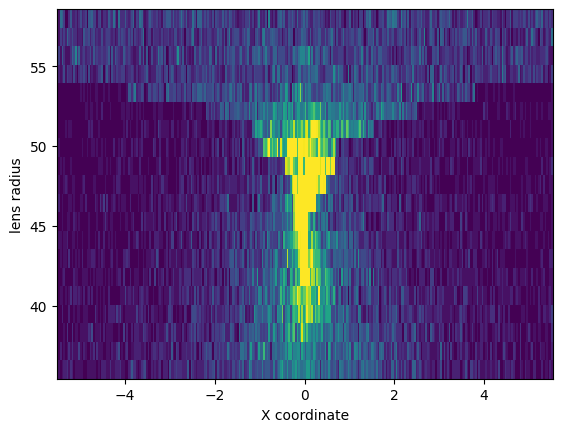

In [12]:
import matplotlib.colors as col
_Hs = array(_Hs)
pcolormesh(X, radii, _Hs, norm=col.Normalize(_Hs.min(), _Hs.max()/5, clip=True))
xlabel('X coordinate')
ylabel('lens radius')
savefig('sweep-result.jpg')

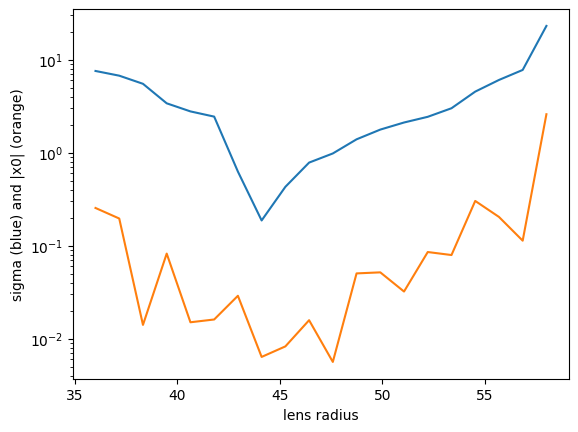

In [13]:
plot(radii, sigmas)
plot(radii, abs(x0s))
xlabel('lens radius')
ylabel('sigma (blue) and |x0| (orange)')
semilogy()
savefig('fit-result.jpg')

# Write best radius to FCStd file

In [16]:
rad = radii[argmin(sigmas)]
with jupyter_utils.FreecadDocument() as f:
  # update radius and placement of both spheres that form the lens
  f.Sphere001.Radius = rad
  f.Sphere001.Placement.Base = [0, 0, -rad/1.2]
  f.Sphere.Radius = rad
  f.Sphere.Placement.Base = [0, 0, rad/1.2]